In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
  epochs_trained=len(h.history['loss'])
  plt.figure(figsize=(16,6))

  plt.subplot(1,2,1)
  plt.plot(range(0,epochs_trained), h.history.get('accuracy'), label ='Training')
  plt.plot(range(0,epochs_trained), h.history.get('val_accuracy'), label ='Validation')
  plt.ylim([0.,1.])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
  from sklearn.metrics import confusion_matrix

  cm=confusion_matrix(y_true, y_pred, normalize='true')

  plt.figure(figsize=(8,8))
  sp=plt.subplot(1,1,1)
  ctx=sp.matshow(cm)
  plt.xticks(list(range(0,6)), labels=classes)
  plt.yticks(list(range(0,6)), labels=classes)
  plt.colorbar(ctx)
  plt.show()


print('Using TensorFlow Version', tf.__version__)

Using TensorFlow Version 2.7.0


In [ ]:
dataset =nlp.load_dataset('emotion')

Using custom data configuration default


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
test=dataset['test']
val=dataset['validation']
train=dataset['train']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels =get_tweet(train)

In [ ]:
tweets[0], labels[0] 

('i didnt feel humiliated', 'sadness')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer =Tokenizer(num_words =10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

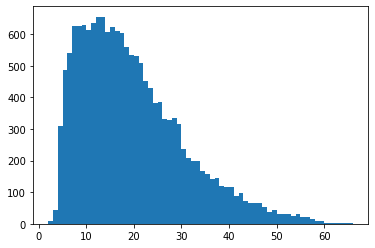

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins =len(set(lengths)))
plt.show()

In [ ]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded= pad_sequences(sequences, truncating='post', padding ='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes =set(labels)
print(classes)

{'joy', 'sadness', 'anger', 'fear', 'love', 'surprise'}


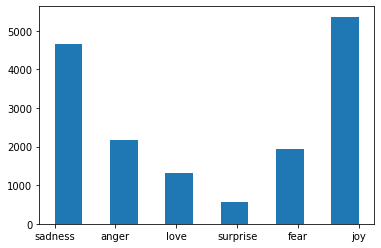

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 2, 'fear': 3, 'joy': 0, 'love': 4, 'sadness': 1, 'surprise': 5}

In [ ]:
index_to_class

{0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                          
])

model.compile(
    
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_tweets, val_labels =get_tweet(val)
val_seq =get_sequences(tokenizer, val_tweets)
val_labels=names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [ ]:
h= model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs =20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience =2)
    ]
)

Epoch 1/20
500/500 [==============================] - 45s 58ms/step - loss: 1.4132 - accuracy: 0.3818 - val_loss: 1.1373 - val_accuracy: 0.5025
Epoch 2/20
500/500 [==============================] - 27s 54ms/step - loss: 0.7752 - accuracy: 0.7019 - val_loss: 0.7041 - val_accuracy: 0.7390
Epoch 3/20
500/500 [==============================] - 27s 54ms/step - loss: 0.4547 - accuracy: 0.8464 - val_loss: 0.4943 - val_accuracy: 0.8350
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.2576 - accuracy: 0.9208 - val_loss: 0.4176 - val_accuracy: 0.8675
Epoch 5/20
500/500 [==============================] - 27s 53ms/step - loss: 0.1861 - accuracy: 0.9426 - val_loss: 0.3852 - val_accuracy: 0.8825
Epoch 6/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1371 - accuracy: 0.9565 - val_loss: 0.3861 - val_accuracy: 0.8800
Epoch 7/20
500/500 [==============================] - 28s 55ms/step - loss: 0.1169 - accuracy: 0.9629 - val_loss: 0.4029 - val_accuracy:

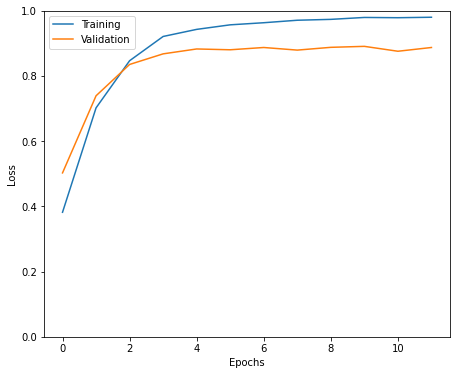

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq=get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_=model.evaluate(test_seq, test_labels)

63/63 [==============================] - 2s 25ms/step - loss: 0.4628 - accuracy: 0.8760


In [ ]:
i=random.randint(0,len(test_labels)-1)
print("Sentance: ",test_tweets[i])
print("Emotion: ", index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ',pred_class)

Sentance:  i feel a kind of dull grief over it
Emotion:  sadness
Predicted Emotion:  sadness


ValueError: ignored